# Drug Design Assistant Using SMILES

Simplified molecular-input line-entry system (SMILES) is a special linear representation of a chemical compound. For example the moelcular formula of Caffeine is C8H10N4O2 while its SMILES is CN1C=NC2=C1C(=O)N(C(=O)N2C)C. SMILES retains some amount of its structural information and at the same time is easy to be processed by a machine.

This project aims to make use of SMILES to assist in the drug design process. Since the structural information is retained, it means that it is possible to make some prediction of the properties of a compound based on just its SMILES string.

Partition coefficient (Kow) is the ratio of concentrations of a compound between an oil phase and a water phase. Partition coefficient is a useful gauge of how a drug would be distributed within the body. The more percentage of it is found in the oil phase the more likely it is to penetrate the phospholipid bilayer of the cells. But if a drug is too lipid loving, it would not be able to dissolve easily in the aqueous region of our body.

In this notebook, Kow is used as the target to be predicted from SMILES string.

Data is taken from a git repository (https://github.com/isayev/ReLeaSE) which is the source code for the paper titled "Deep Reinforcement Learning for de-novo Drug Design (https://arxiv.org/pdf/1711.10907.pdf). This notebook is not an implementation of this paper. It is only a baseline model built using TensorFlow 2.0 and their data set.

# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# SMILES Processing

### Tokenize SMILES by Character

In [2]:
smiles_df = pd.read_csv('./data/release/logP_labels.csv')

smiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14176 entries, 0 to 14175
Data columns (total 2 columns):
SMILES    14176 non-null object
Kow       14176 non-null float64
dtypes: float64(1), object(1)
memory usage: 221.6+ KB


In [3]:
smiles_df.head()

,SMILES,Kow
0,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,1.885
1,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,2.190
2,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,2.100
3,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,1.470
4,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,-0.400


In [4]:
smiles_df.SMILES.str.len().max()

167

In [5]:
tokenizer = Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(smiles_df['SMILES'])

print(tokenizer.word_index)

{'c': 1, 'C': 2, '(': 3, ')': 4, 'O': 5, '1': 6, '=': 7, 'N': 8, '2': 9, 'n': 10, 'l': 11, '[': 12, ']': 13, '3': 14, '-': 15, 'S': 16, 'F': 17, '+': 18, 'H': 19, '4': 20, '#': 21, 'B': 22, 'r': 23, 'o': 24, 's': 25, 'P': 26, 'I': 27, '5': 28, '6': 29, 'i': 30, '7': 31, 'e': 32, 'A': 33}


In [6]:
token_dict = tokenizer.word_index

In [7]:
tokenized_smiles = smiles_df['SMILES'].apply(list)
tokenized_smiles.shape

(14176,)

In [8]:
print(tokenized_smiles[0])

['C', 'C', '1', 'C', 'C', '2', 'C', '3', 'C', 'C', 'C', '4', '=', 'C', 'C', '(', '=', 'O', ')', 'C', '=', 'C', 'C', '4', '(', 'C', ')', 'C', '3', '(', 'F', ')', 'C', '(', 'O', ')', 'C', 'C', '2', '(', 'C', ')', 'C', '1', '(', 'O', ')', 'C', '(', '=', 'O', ')', 'C', 'O']


### Convert SMILES Tokens to Indices

In [9]:
def to_word_indices(smiles_tokens):
    smiles_indices = []
    for token in smiles_tokens:
        smiles_indices.append(token_dict[token])
    
    return smiles_indices

In [10]:
tokenized_smiles_indices = tokenized_smiles.apply(to_word_indices)

In [11]:
print(tokenized_smiles_indices[0])

[2, 2, 6, 2, 2, 9, 2, 14, 2, 2, 2, 20, 7, 2, 2, 3, 7, 5, 4, 2, 7, 2, 2, 20, 3, 2, 4, 2, 14, 3, 17, 4, 2, 3, 5, 4, 2, 2, 9, 3, 2, 4, 2, 6, 3, 5, 4, 2, 3, 7, 5, 4, 2, 5]


### Pad Each Sequence & Data Split

The longest SMILES string in this data set is found to be 167 character long. The maximum length to pad each sequence is arbitrary set to 170. This would be a point to consider in future iteration of the model.

In [12]:
maxlen = 170

tokenized_smiles_indices = preprocessing.sequence.pad_sequences(tokenized_smiles_indices, maxlen=maxlen, padding='post', truncating='post')

In [13]:
print(tokenized_smiles_indices[0])

[ 2  2  6  2  2  9  2 14  2  2  2 20  7  2  2  3  7  5  4  2  7  2  2 20
  3  2  4  2 14  3 17  4  2  3  5  4  2  2  9  3  2  4  2  6  3  5  4  2
  3  7  5  4  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [14]:
x_train, x_test, y_train, y_test = train_test_split(tokenized_smiles_indices, smiles_df['Kow'], test_size=0.2, random_state=42)

In [15]:
x_train.shape

(11340, 170)

In [16]:
x_test.shape

(2836, 170)

In [17]:
x_val = x_train[:2800]
partial_x_train = x_train[2800:]
y_val = y_train[:2800]
partial_y_train = y_train[2800:]

The data set is roughly split into train (60%), cross validation (20%) and test (20%).

# Baseline Model

### Epoch Tuning

In [18]:
embedding_size = len(token_dict) + 1

In [19]:
model = keras.Sequential()
model.add(keras.layers.Embedding(embedding_size, 8, input_length=maxlen))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 8)            272       
_________________________________________________________________
flatten (Flatten)            (None, 1360)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                21776     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 22,065
Trainable params: 22,065
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [21]:
history = model.fit(partial_x_train, partial_y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val))

Train on 8540 samples, validate on 2800 samples
Epoch 1/100
8540/8540 [==============================] - 1s 87us/sample - loss: 2.1441 - mae: 1.0778 - val_loss: 1.3317 - val_mae: 0.8511
Epoch 2/100
8540/8540 [==============================] - 1s 69us/sample - loss: 1.2919 - mae: 0.8285 - val_loss: 1.2138 - val_mae: 0.8210
Epoch 3/100
8540/8540 [==============================] - 1s 67us/sample - loss: 1.1925 - mae: 0.7969 - val_loss: 1.1257 - val_mae: 0.7887
Epoch 4/100
8540/8540 [==============================] - 1s 67us/sample - loss: 1.1191 - mae: 0.7738 - val_loss: 1.0842 - val_mae: 0.7779
Epoch 5/100
8540/8540 [==============================] - 1s 67us/sample - loss: 1.0506 - mae: 0.7515 - val_loss: 1.0613 - val_mae: 0.7693
Epoch 6/100
8540/8540 [==============================] - 1s 68us/sample - loss: 0.9955 - mae: 0.7348 - val_loss: 1.0324 - val_mae: 0.7598
Epoch 7/100
8540/8540 [==============================] - 1s 66us/sample - loss: 0.9364 - mae: 0.7138 - val_loss: 1.0548 - va

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

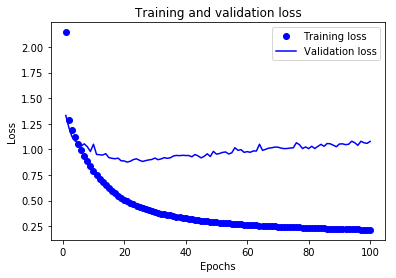

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 100 + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
history.history

{'loss': [2.144062515611671,
  1.2918609768222031,
  1.1925167789503897,
  1.1190894679665844,
  1.0506354536887355,
  0.9954887242172027,
  0.9363780340768694,
  0.8866500505239678,
  0.8379312626930254,
  0.7932429152992346,
  0.7531115094727598,
  0.7139078208378383,
  0.6818733396798163,
  0.6482158989202781,
  0.6201262441814923,
  0.5928413244963251,
  0.5720543190243652,
  0.5469068593107844,
  0.5277632518869931,
  0.5112111038709413,
  0.49331763615652885,
  0.4783122073850252,
  0.46557229275027817,
  0.45136416209665337,
  0.439973736060587,
  0.4290451199165273,
  0.41587182639354286,
  0.4071430362220112,
  0.3950790248514618,
  0.3876362253407963,
  0.3842871705877139,
  0.37082436166407073,
  0.3655965578918993,
  0.3594460900061583,
  0.3553045355673417,
  0.34582527968029225,
  0.34135455729252284,
  0.33598596163320876,
  0.3298172595489779,
  0.32653488879739817,
  0.32268176994502407,
  0.31675810406302957,
  0.3118479224920831,
  0.3097200809513378,
  0.30506618869

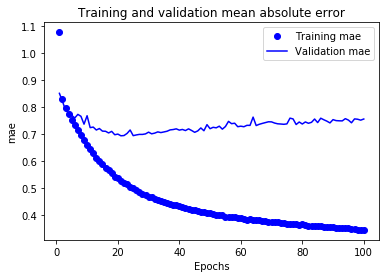

In [25]:
plt.clf()
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
plt.plot(epochs, mae_values, 'bo', label='Training mae')
plt.plot(epochs, val_mae_values, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

### Retrain Model with Tuned Epoch

Epoch was set to 16, as it was the point before the validation scores started to get unstable and started to increase

In [26]:
model = keras.Sequential()
model.add(keras.layers.Embedding(embedding_size, 8, input_length=maxlen))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=16, batch_size=16)

Epoch 1/16
11340/11340 [==============================] - 1s 62us/sample - loss: 1.9985 - mae: 1.0443
Epoch 2/16
11340/11340 [==============================] - 1s 58us/sample - loss: 1.2232 - mae: 0.8102
Epoch 3/16
11340/11340 [==============================] - 1s 57us/sample - loss: 1.1377 - mae: 0.7851
Epoch 4/16
11340/11340 [==============================] - 1s 56us/sample - loss: 1.0627 - mae: 0.7596
Epoch 5/16
11340/11340 [==============================] - 1s 57us/sample - loss: 1.0030 - mae: 0.7383
Epoch 6/16
11340/11340 [==============================] - 1s 59us/sample - loss: 0.9417 - mae: 0.7198
Epoch 7/16
11340/11340 [==============================] - 1s 57us/sample - loss: 0.8874 - mae: 0.6959
Epoch 8/16
11340/11340 [==============================] - 1s 59us/sample - loss: 0.8376 - mae: 0.6780
Epoch 9/16
11340/11340 [==============================] - 1s 59us/sample - loss: 0.7909 - mae: 0.6566
Epoch 10/16
11340/11340 [==============================] - 1s 57us/sample - loss: 

### Evaluate Model

In [27]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

2836/2836 [==============================] - 0s 26us/sample - loss: 0.8323 - mae: 0.6727


In [28]:
test_mse_score

0.8322533696931912

In [29]:
test_mae_score

0.6727048

In [30]:
smiles_df['Kow'].max()

11.29

In [31]:
smiles_df['Kow'].min()

-5.4

The range of the partition coefficient in this data set is between -5.4 to 11.29 and the baseline model have a mean absolute error of about 0.67.

### Future Work

1) Explore other model architecture to beat the baseline.
<br>
2) Expand to other prediction targets.
<br>
3) Deploy the model.